In [1]:
import ray
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
from pettingzoo.classic import texas_holdem_v4

def env_creator(_config=None):
    # raw PettingZoo AEC env
    env = texas_holdem_v4.env()
    # RLlib wrapper so it looks like a MultiAgentEnv
    return PettingZooEnv(env)

env_name = "texas_holdem_v4"
register_env(env_name, lambda config: env_creator(config))

# Create one test env to grab spaces
test_env = env_creator()
obs_space = test_env.observation_space
act_space = test_env.action_space

In [2]:
test_env = texas_holdem_v4.env(render_mode="human")
test_env.reset()
obs, reward, termination, truncation, info = test_env.last()

print("obs['observation'].shape:", obs["observation"].shape)
print("obs['action_mask']:", obs["action_mask"])

obs['observation'].shape: (72,)
obs['action_mask']: [1 1 1 0]


In [3]:
from pettingzoo.classic import texas_holdem_v4

env = texas_holdem_v4.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        mask = observation["action_mask"]
        # this is where you would insert your policy
        action = env.action_space(agent).sample(mask)

    env.step(action)
env.close()


In [4]:
obs_space

Dict('player_0': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)), 'player_1': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)))

In [5]:
act_space

Dict('player_0': Discrete(4), 'player_1': Discrete(4))

In [6]:
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.utils.framework import try_import_torch
import gymnasium as gym

torch, nn = try_import_torch()

import numpy as np
import gymnasium as gym

from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()

class FlatActionMaskingModel(TorchModelV2, nn.Module):
    """
    处理 RLlib 已经 flatten 好的 Box 观测：
    obs_flat = concat([action_mask(4), observation_vec(...)])

    RLlib 对 Dict 的 flatten 顺序是按 key 排序的：
    "action_mask" < "observation"
    所以前 4 维是 mask，后面是真正的观测。
    """
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        print(">>> FlatActionMaskingModel obs_space:", obs_space)
        print(">>> type(obs_space):", type(obs_space))

        # 现在 obs_space 就是 Box(152,)
        assert isinstance(obs_space, gym.spaces.Box), \
            f"Expected flat Box obs space, got {obs_space!r}"

        flat_dim = int(np.prod(obs_space.shape))   # 比如 152
        mask_dim = action_space.n                  # Discrete(4) -> 4
        obs_dim  = flat_dim - mask_dim             # 152 - 4 = 148

        if obs_dim <= 0:
            raise ValueError(
                f"flat_dim ({flat_dim}) <= mask_dim ({mask_dim}); "
                f"can't split into obs + mask."
            )

        self.obs_dim  = obs_dim
        self.mask_dim = mask_dim

        # base_model 只看「观测部分」，不看 mask
        obs_low  = np.full((obs_dim,),  obs_space.low.min(),  dtype=np.float32)
        obs_high = np.full((obs_dim,),  obs_space.high.max(), dtype=np.float32)
        obs_box  = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.base_model = FullyConnectedNetwork(
            obs_space=obs_box,
            action_space=action_space,
            num_outputs=num_outputs,  # 对 PPO 就是 4
            model_config=model_config,
            name=name + "_fcnet",
        )

    def forward(self, input_dict, state, seq_lens):
        # 这里的 obs 已经是 Box(152,) flatten 好的
        flat = input_dict["obs"].float()      # [B, flat_dim]

        # 按约定：前 4 维是 action_mask，后面是 observation
        raw_mask = flat[..., :self.mask_dim]      # [B, 4]
        obs      = flat[..., self.mask_dim:]      # [B, obs_dim]

        # 强制 mask 为 0/1
        legal_mask = (raw_mask > 0.5).float()

        # base_model 只看 obs
        logits, _ = self.base_model({"obs": obs}, state, seq_lens)  # [B, 4]

        # 对非法动作加 -inf
        inf = torch.finfo(logits.dtype).min
        mask_add = (1.0 - legal_mask) * inf
        masked_logits = logits + mask_add

        return masked_logits, state

    def value_function(self):
        return self.base_model.value_function()


# 注册到 ModelCatalog，后面用字符串引用
ModelCatalog.register_custom_model("flat_action_mask_model", FlatActionMaskingModel)


In [8]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.ppo import PPOConfig
import gymnasium as gym
from ray.rllib.policy.policy import PolicySpec

# Option A: two separate policies (one per seat)
config = (
    PPOConfig()
    .environment(env=env_name)
    .framework("torch")
    .env_runners(
        num_env_runners=4,
        create_env_on_local_worker=True,
    )
    .training(
        gamma=0.99,
        lr=1e-3,
        train_batch_size=64,
        minibatch_size=32,
        model={
            # ✅ 这里：用刚才注册的名字，而不是类本身
            "custom_model": "flat_action_mask_model",
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
            # 让 obs 以 Dict 形式传进我们自定义模型
            "_disable_preprocessor_api": True,
        },
    )
    .multi_agent(
        policies={
            # 让 RLlib 自己从 env 推断 obs_space / act_space
            "player_0": PolicySpec(config={}),
            "player_1": PolicySpec(config={}),
        },
        policy_mapping_fn=lambda agent_id, *a, **k: agent_id,
    )

    .api_stack(
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False,
    )
)



algo = config.build()



c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\rllib\algorithms\algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be 

(RolloutWorker pid=1132) >>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
(RolloutWorker pid=1132) >>> type(obs_space): <class 'gymnasium.spaces.box.Box'>


2025-11-24 21:42:02,072	INFO trainable.py:161 -- Trainable.setup took 17.102 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-11-24 21:42:02,075	WARNING util.py:61 -- Install gputil for GPU system monitoring.


>>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
>>> type(obs_space): <class 'gymnasium.spaces.box.Box'>
>>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
>>> type(obs_space): <class 'gymnasium.spaces.box.Box'>


In [9]:
import collections

env = env_creator({})

def eval_one_episode(render=False):
    obs, info = env.reset()
    done = False

    # Start empty; we'll add agents as we see them
    ep_reward = collections.defaultdict(float)
    length = 0

    while not done:
        if render:
            env.render()

        actions = {}
        print(obs.items())
        for agent_id, agent_obs in obs.items():
            action = algo.compute_single_action(
                agent_obs,
                policy_id=agent_id,
                explore=False,
            )
            actions[agent_id] = int(action)  # Discrete(4) -> int

        obs, rewards, terminated, truncated, infos = env.step(actions)
        length += 1

        # accumulate rewards; skip special keys like "__all__"
        for aid, r in rewards.items():
            if aid == "__all__":
                continue
            ep_reward[aid] += r

        # episode done: use "__all__" if provided, else fall back
        if "__all__" in terminated:
            done = terminated["__all__"] or truncated.get("__all__", False)
        else:
            done = all(terminated.values()) or all(truncated.values())

    return dict(ep_reward), length

# Run ONE eval episode
ep_rew, ep_len = eval_one_episode(render=False)
print("Episode length:", ep_len)
print("Episode rewards:", ep_rew)


2025-11-24 21:42:04,106	WARNING 672172012.py:20 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


dict_items([('player_0', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
dict_items([('player_1', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
Episode length: 2
Episode rewards: {'player_1': np.float64(-1.0), 'player_0': np.float64(1.0)}


In [10]:
rewards = []
lengths = []
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

import torch
def plot_metrics(rewards, lengths):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # plt.subplots(ncols=2, figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title('Mean Rewards')
    ax1.set_xlabel('Evaluation Interval')
    ax1.set_ylabel('Mean Reward')
    ax1.plot(rewards)

    ax2.set_title('Mean Episode Length')
    ax2.set_xlabel('Evaluation Interval')
    ax2.set_ylabel('Episode Length')
    ax2.plot(lengths)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

Training:   0%|          | 0/500 [05:43<?, ?iter/s]


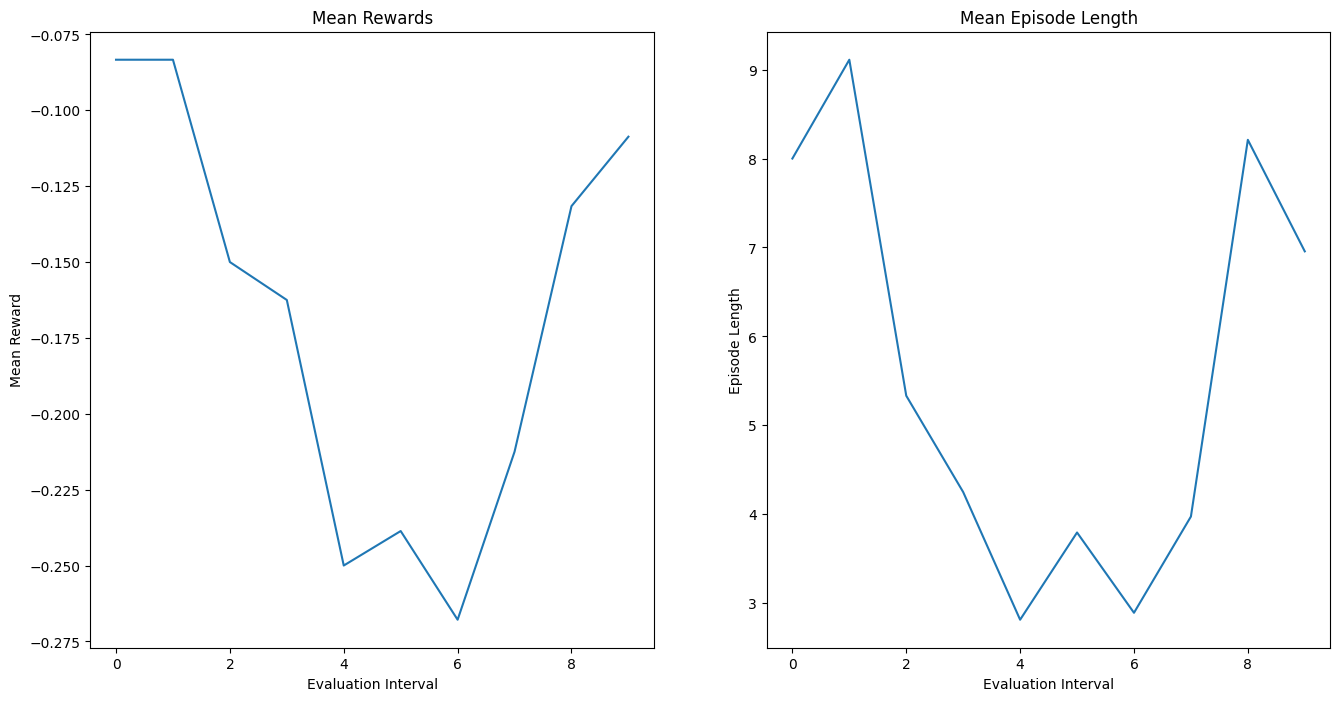

In [11]:
TRAINING_ITERATIONS = 500
EVAL_INTERVAL = 50
from tqdm import tqdm


with tqdm(total=TRAINING_ITERATIONS, desc="Training", unit="iter") as pbar:
    for i in range(TRAINING_ITERATIONS):
        algo.train()

        if (i+1) % EVAL_INTERVAL == 0:
            # metrics = algo.evaluate()['evaluation']
            # rewards.append(metrics['episode_reward_mean'])
            # lengths.append(metrics['episode_len_mean'])
            metrics = algo.evaluate()
            metrics = metrics["env_runners"]

            r_mean = metrics["episode_return_mean"]
            l_mean = metrics["episode_len_mean"]

            rewards.append(r_mean)
            lengths.append(l_mean)
            plot_metrics(rewards, lengths)

In [12]:
import numpy as np

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def decode_visible_cards(obs_dict):
    """Return list of human-readable cards visible to this player."""
    vec = obs_dict["observation"]
    # ensure it's a flat array
    vec = np.array(vec).astype(int)

    cards_bits = vec[:52]
    cards = []
    for i, bit in enumerate(cards_bits):
        if bit == 1:
            suit = SUITS[i // 13]
            rank = RANKS[i % 13]
            cards.append(f"{rank} of {suit}")
    return cards
ACTION_NAMES = {
    0: "Call",
    1: "Raise",
    2: "Fold",
    3: "Check",
}


In [13]:
import imageio
import torch
from PIL import Image

rmode = "rgb_array"

env = texas_holdem_v4.env(render_mode=rmode)
env.reset(seed=42)
frames = []
for agent in env.agent_iter():
    print("-------------------")
    print(agent)
    obs, reward, termination, truncation, info = env.last()
    # print(observation)
    visible_cards = decode_visible_cards(obs)
    print("Visible cards:", visible_cards)
    print("Reward so far:", reward)
    if termination or truncation:
        action = None
        print("-------------------")
    else:
        rllib_obs = {
                "action_mask": obs["action_mask"],
                "observation": obs["observation"],
            }

        # policy_id MUST match the agent name ("player_0" / "player_1")
        action = algo.compute_single_action(
                rllib_obs,
                policy_id=agent,
                explore=True,      # deterministic eval
        )
        action_name = ACTION_NAMES.get(int(action), f"Unknown({action})")

        print("Chosen action:", action_name)
        print("-------------------")
    if rmode == "rgb_array":
        frame = env.render()
        if frame is not None:
            frames.append(frame)
    env.step(action)

env.close()


if rmode != "human":
   imageio.mimsave("ppo_poke.gif", frames, fps=30)
   print("Saved to ppo_poke.gif")

-------------------
player_0
Visible cards: ['Q of Spades', '7 of Clubs']
Reward so far: 0
Chosen action: Call
-------------------
-------------------
player_1
Visible cards: ['K of Hearts', '4 of Diamonds']
Reward so far: 0
Chosen action: Fold
-------------------
-------------------
player_0
Visible cards: ['Q of Spades', '7 of Clubs']
Reward so far: 1.0
-------------------
-------------------
player_1
Visible cards: ['K of Hearts', '4 of Diamonds']
Reward so far: -1.0
-------------------
Saved to ppo_poke.gif
